In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
from scipy import spatial

from utils import sph2cart, remove_hidden_points
from plotting import set_axes_equal, set_defense_context

In [2]:
%config InlineBackend.figure_format = 'retina'

In [5]:
def sphere(r, samples=1000):
    # https://stackoverflow.com/a/44164075/15005103
    i = np.arange(0, samples, dtype=float) + 0.5
    phi = np.arccos(1 - 2 * i / samples)
    theta = np.pi * (1 + np.sqrt(5)) * i
    x = r * np.cos(theta) * np.sin(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(phi)
    return np.c_[x, y, z]


def estimate_normals_spline(xyz, unit=True, orient=False):
    n = np.empty_like(xyz)
    tree = spatial.KDTree(xyz)
    for i, query_point in enumerate(xyz):
        nbh_dist, nbh_idx = tree.query([query_point], k=30)
        query_nbh = xyz[nbh_idx.flatten()]

        X = query_nbh.copy()
        X_norm = X - X.mean(axis=0)
        U, S, VT = np.linalg.svd(X_norm.T)
        X_trans = X_norm @ U

        h = interpolate.SmoothBivariateSpline(*X_trans.T)

        ni = np.array([-h(*X_trans[0, :2], dx=1, grid=False).item(),
                       -h(*X_trans[0, :2], dy=1, grid=False).item(),
                       1])
        ni = np.dot(U, ni)
        if unit:
            ni = np.divide(ni, np.linalg.norm(ni, 2))
        n[i, :] = ni
    if orient:
        n = _orient_normals(xyz, n)
    return n


def _orient_normals(xyz, n):
    center = np.mean(xyz, axis=0)
    for i in range(xyz.shape[0]):
        pi = xyz[i, :] - center
        ni = n[i]
        angle = np.arccos(np.clip(np.dot(ni, pi), -1.0, 1.0))
        if (angle > np.pi/2) or (angle < -np.pi/2):
            n[i] = -ni
    return n

In [12]:
# generate coordinates of a sphere

r = 5  # cm
samples = 10000
xyz = sphere(r, samples)
n = estimate_normals_spline(xyz, unit=False, orient=True)

In [13]:
# create 2 synthetic absorbed power density patterns

mask = np.where(xyz[:, 0] > 0)[0]  # the wave propagates in the x-direction
y = xyz[mask, 1]
z = xyz[mask, 2]

center_1 = [0, 0]
radius_1 = 0.5
region_1 = np.sqrt(((y - center_1[0]) / 1.5) ** 2 + (z - center_1[1]) ** 2)
color_1 = 15.1 * np.exp(-(region_1 / radius_1) ** 2)

center_2 = [2.5, -1]
radius_2 = 1.5
region_2 = np.sqrt((y - center_2[0]) ** 2 + (z - center_2[1]) ** 2)
color_2 = 10 * np.exp(-(region_2 / radius_2) ** 2)

color = np.zeros((xyz.shape[0], ))
color[mask] = color_1 + color_2

# Incident wave direction is known

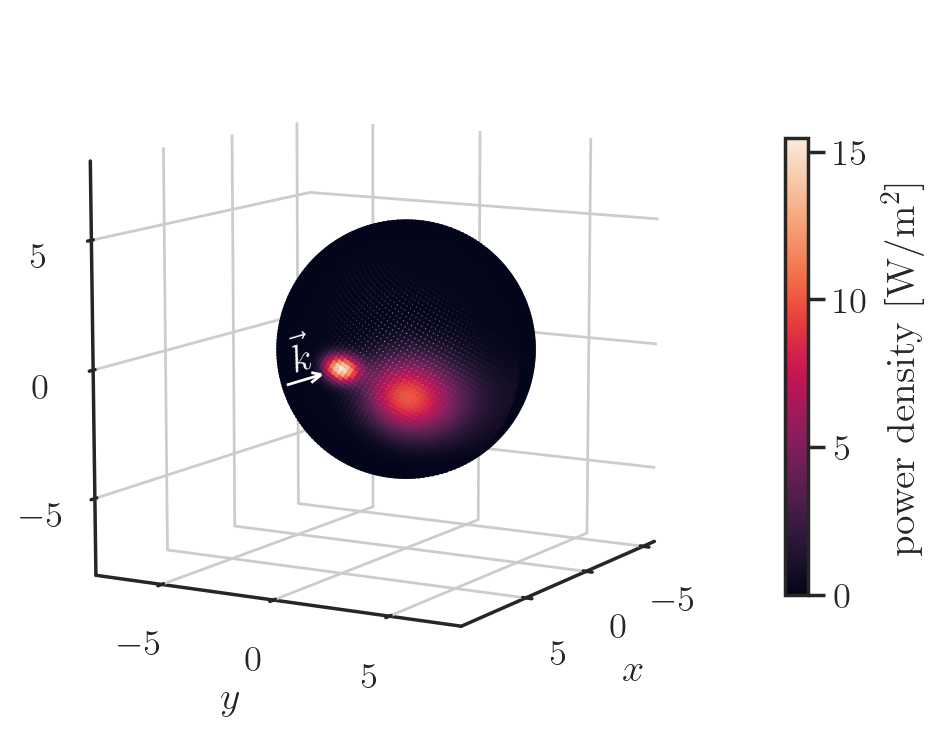

In [14]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz.T, c=color, s=1, depthshade=True)
    ax.quiver(9, 0, 0, -2.5, 0, 0, lw=1, color='w')
    ax.text(9, 0, 0.5, s='$\\vec k$', color='w', zdir='x')
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(10, 30)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    fig.tight_layout()
    plt.show()

In [63]:
# step 1) extract visible points from the assumed direction of incidence

center = np.mean(xyz, axis=0)
diameter = np.linalg.norm(xyz.max(axis=0) - xyz.min(axis=0))
pov = center.copy()
pov[0] += diameter
idx_visible = remove_hidden_points(xyz, pov, np.pi)
xyz_visible = xyz[idx_visible]
color_visible = color[idx_visible]

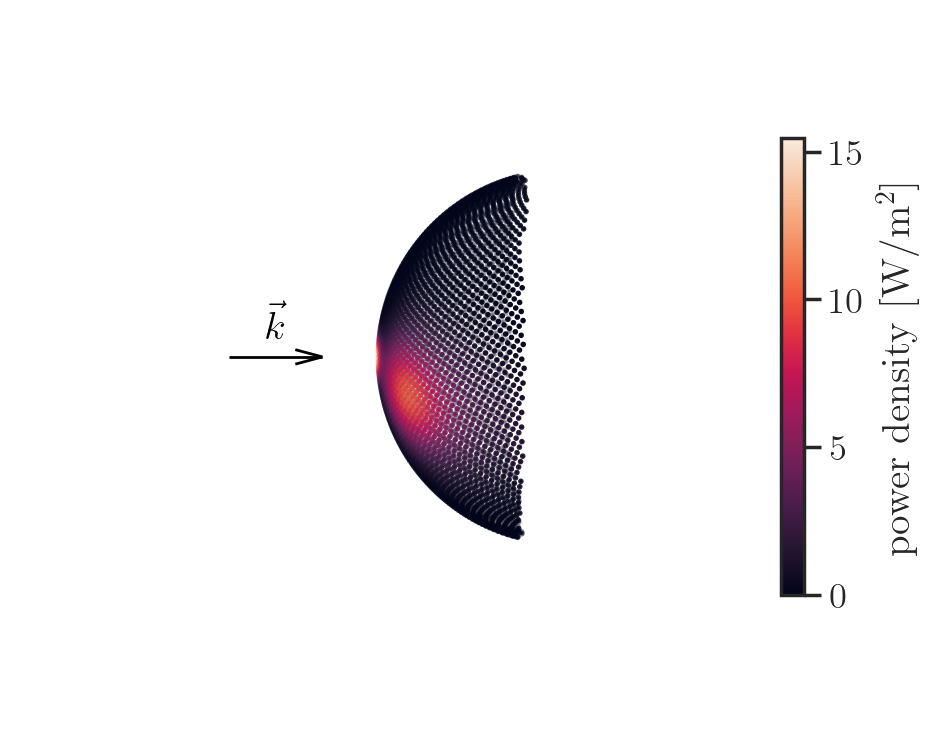

In [64]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz_visible.T, c=color_visible, s=1, depthshade=True)
    ax.quiver(9, 0, 0, -2.5, 0, 0, lw=1, color='k')
    ax.text(8, 0, 0.5, s='$\\vec k$', color='k', zdir='x')
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(0, 90)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    ax.set_axis_off()
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    fig.tight_layout()
    plt.show()

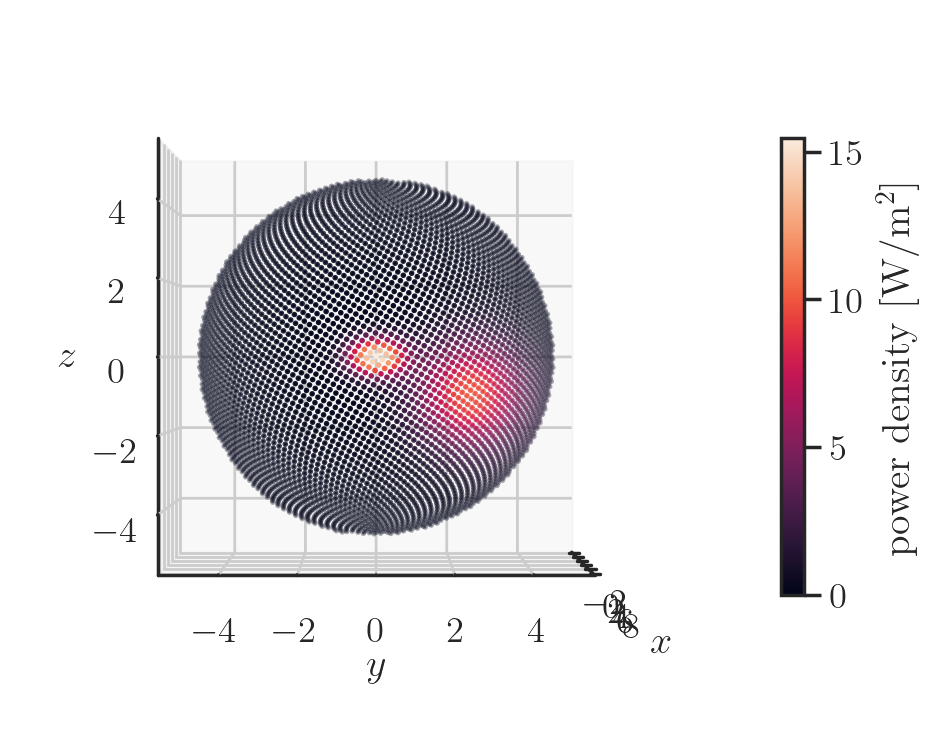

In [65]:
with set_defense_context():
    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*xyz_visible.T, c=color_visible, s=1, depthshade=True)
    ax.set(xlabel='$x$', ylabel='$y$', zlabel='$z$')
    ax.view_init(0, 0)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    #ax.set_axis_off()
    fig.colorbar(s, ax=ax, pad=0.075, shrink=0.5,
                 label='power density [W/m$^2$]')
    fig.tight_layout()
    plt.show()

In [88]:
# step 2) extract 2x2 or 1x1 cm2 areas in a plane perpendicular to k vector

area = 4  # cm2
a = np.sqrt(area)
count = 0
for query_point in xyz_visible:
    _bbox = [query_point[1]-a/2,
             query_point[1]+a/2,
             query_point[2]-a/2,
             query_point[2]+a/2]
    _mask = np.where((xyz_visible[:, 1] > _bbox[0])
                     & (xyz_visible[:, 1] <= _bbox[1])
                     & (xyz_visible[:, 2] > _bbox[2])
                     & (xyz_visible[:, 2] <= _bbox[3]))[0]
    query_surface = xyz_visible[_mask]
    query_hull = spatial.ConvexHull(query_surface[:, 1:])  # incorrect
    if np.abs(query_hull.area - area) > 0.1:
        continue
    else:
        count += 1

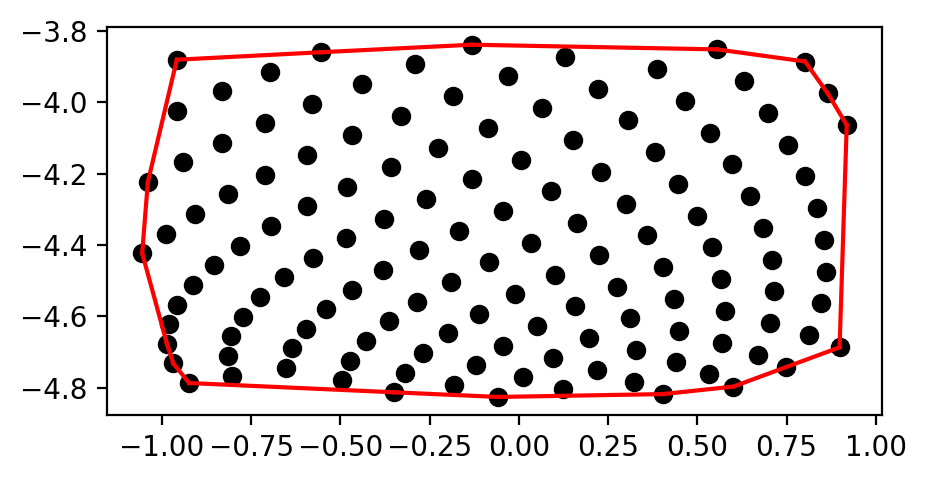

In [115]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

ax.plot(*query_surface[:, 1:].T, 'ko')

for s in query_hull.simplices:
    ax.plot(query_surface[s, 1], query_surface[s, 2], 'r-')
ax.set_aspect('equal', 'box')
plt.show()

In [117]:
query_hull.area

5.388638864989708

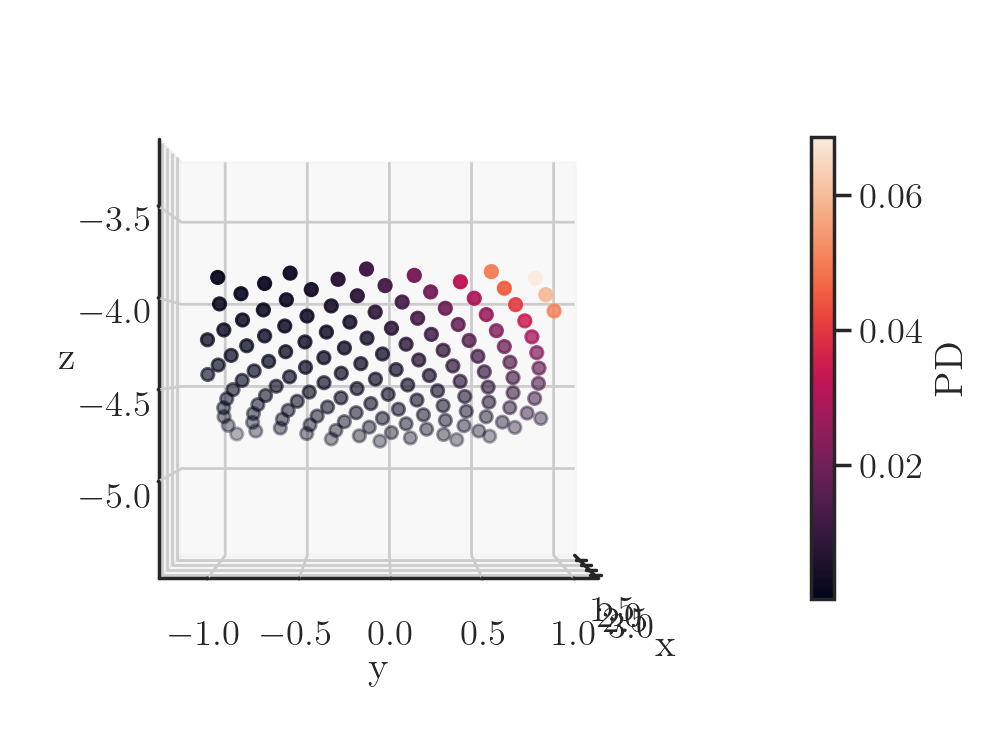

In [101]:
with set_defense_context():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*query_surface.T, c=color_visible[_mask])
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    ax.view_init(0, 0)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    fig.colorbar(s, ax=ax, pad=0.1, shrink=0.5, label='PD')
    plt.show()

# Incident wave direction is unknown

In [104]:
area = 4  # square-shaped surface in cm2
r = np.sqrt(A / np.pi)

query_point = xyz[np.where(color == color.max())[0][0]]
bbox = [query_point[1]-a/2, query_point[1]+a/2,
        query_point[2]-a/2, query_point[2]+a/2]

tree = spatial.KDTree(xyz)
nbh_idx = tree.query_ball_point([query_point], r)[0]
query_nbh = xyz[nbh_idx]

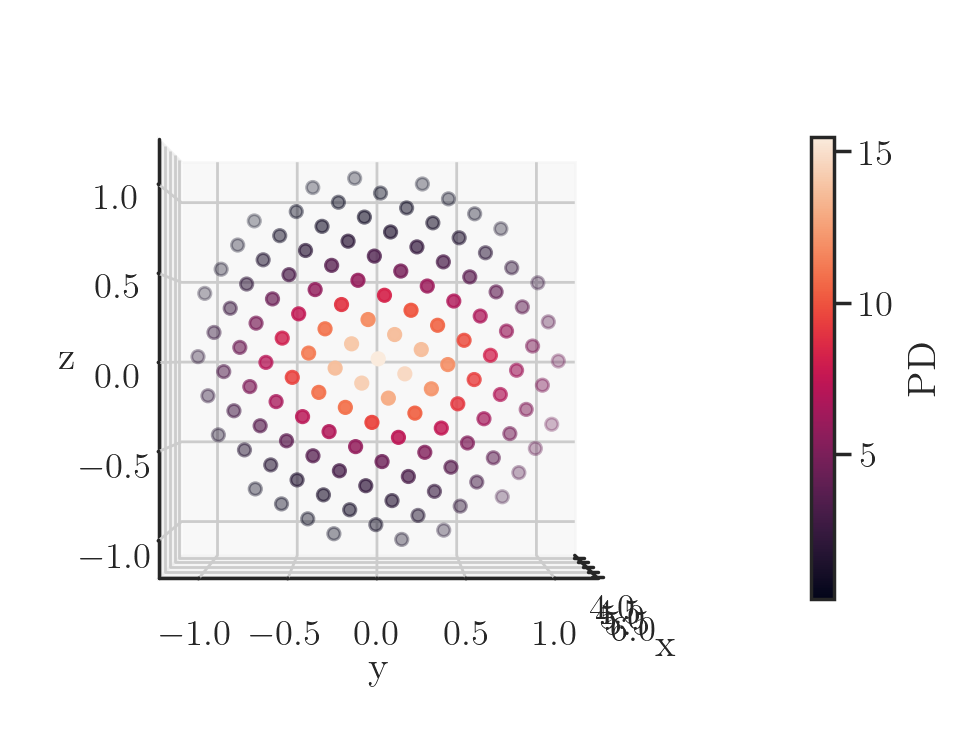

In [105]:
with set_defense_context():
    fig = plt.figure(figsize=(6, 6))
    ax = plt.axes(projection ='3d')
    s = ax.scatter(*query_nbh.T, c=color[nbh_idx])
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    ax.view_init(0, 0)
    ax.set_box_aspect([1, 1, 1])
    ax = set_axes_equal(ax)
    fig.colorbar(s, ax=ax, pad=0.1, shrink=0.5, label='PD')
    plt.show()